In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import sys
import copy

In [2]:
def classify (img, correct_class=None, target_class=None, show_image=False):
    # copy image to new object
    tensor_img = copy.deepcopy(img)
    tensor_img = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                      std=[0.229, 0.224, 0.225])(tensor_img)
    tensor_img = tensor_img.unsqueeze_(0).to(device)

    net.eval()
    outputs = net(tensor_img)[0]
    outputs = F.softmax(outputs, dim=0)

    # Retrieve the sorted output with categories
    sorted_outputs, indices = torch.sort(outputs, descending=True) 
    indices = indices.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    topk = list(indices[:10])
    topprobs = outputs[topk]
    
    if show_image:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,8))
        barlist = ax2.bar(range(10), topprobs)

        if target_class in topk:
            barlist[topk.index(target_class)].set_color('r')
        if correct_class in topk:
            barlist[topk.index(correct_class)].set_color('g')

        fig.sca(ax1)
        ax1.imshow(transforms.ToPILImage()(img))
        plt.sca(ax2)
        plt.ylim([0, 1.1])

        plt.xticks(range(10), 
                   [imagenet_labels[i][:15] for i in topk], 
                   rotation = 'vertical')
        fig.subplots_adjust(bottom = 0.2)
        plt.show()
    
    return tensor_img

In [3]:
def numpy_to_tensor(img, requires_grad = False):
    if len(img.shape) > 3:
        out = img.squeeze().detach().cpu().numpy()
        out = out.transpose((1, 2, 0))# [N,C,H,W]->[H,W,C]
    else:
        out = np.transpose(img, (2, 0, 1))
        out = torch.from_numpy(out)
        out = out.unsqueeze(0).to(device)
        out.requires_grad = requires_grad # [H,W,C]->[N,C,H,W]
    return out

In [4]:
def show(img):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img)
    ax.imshow(img)

In [5]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

tv_beta = 2
l1_coeff = 1
tv_coeff = 1

In [6]:
#Initialize random number generators
# np.random.seed(1234)
# torch.manual_seed(1234)
img_class = 281 # chainlink fence
target_img_class = 924 # guacamole
learning_rate_gd = 1e-1
momentum = 0.9
epsilon = 2.0/255.0
loss_threshold = 1e-6
steps = 200
source_img_filename = 'cat.jpg'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

imagenet_json = "imagenet.json"
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [7]:
# Load pre-trained model
net = models.inception_v3(pretrained=True).to(device)

source_img = Image.open(source_img_filename)
x_img = transforms.Compose([transforms.Resize(299), 
                            transforms.CenterCrop(299), 
                            transforms.ToTensor()])(source_img)

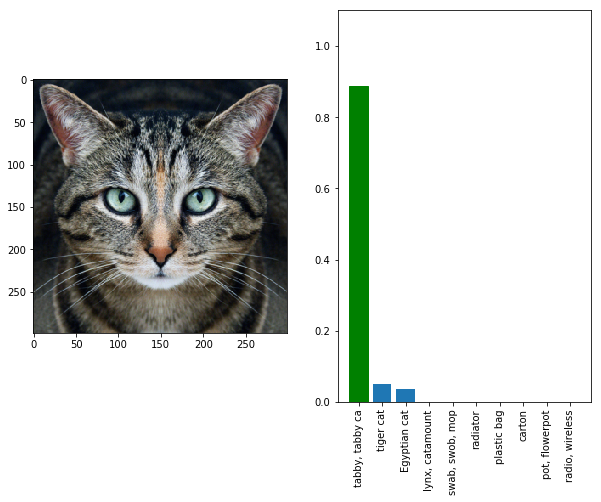

In [8]:
_ = classify(x_img, correct_class = img_class, show_image=True)

In [9]:
x_img = x_img.unsqueeze(0)
blur_img = numpy_to_tensor(x_img)
blur_img = cv2.GaussianBlur(blur_img, (11, 11), 5)

blur_img = np.transpose(blur_img, (2, 0, 1))
blur_img = torch.from_numpy(blur_img)

# show(blur_img)

Starting adversarial training...
Progress : pass 10/200; loss = 10.678971290588379
Progress : pass 20/200; loss = 10.576690673828125
Progress : pass 30/200; loss = 10.47856616973877
Progress : pass 40/200; loss = 10.385641098022461
Progress : pass 50/200; loss = 10.297415733337402
Progress : pass 60/200; loss = 10.21069049835205
Progress : pass 70/200; loss = 10.129669189453125
Progress : pass 80/200; loss = 10.053707122802734
Progress : pass 90/200; loss = 9.982267379760742
Progress : pass 100/200; loss = 9.915288925170898
Progress : pass 110/200; loss = 9.850726127624512
Progress : pass 120/200; loss = 9.790761947631836
Progress : pass 130/200; loss = 9.7347993850708
Progress : pass 140/200; loss = 9.681477546691895
Progress : pass 150/200; loss = 9.63095474243164
Progress : pass 160/200; loss = 9.582353591918945
Progress : pass 170/200; loss = 9.535604476928711
Progress : pass 180/200; loss = 9.490337371826172
Progress : pass 190/200; loss = 9.446728706359863
Progress : pass 200/200

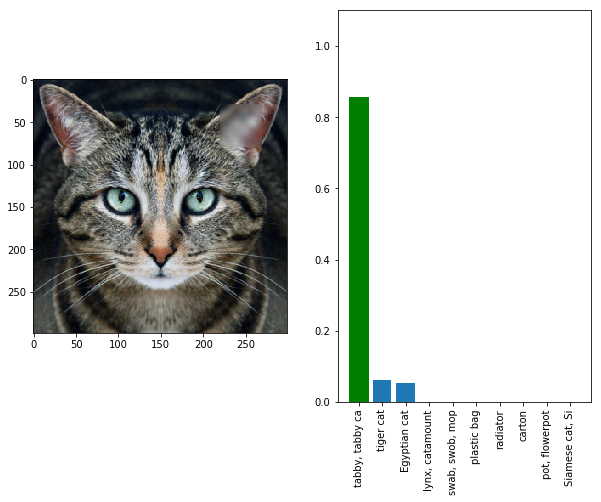

In [10]:
# Create new output image initialized with existing image
# x_img = x_img.unsqueeze(0)
# x_hat = copy.deepcopy(x_img).to(device)
mask = torch.zeros(1,3,299,299).to(device)
mask[:,:,30:80,220:270] = 1
# mask = mask * epsilon

pert = blur_img.unsqueeze(0).to(device)
# mask = pert.mul(mask)


# GD step
y_hat_target = torch.LongTensor(1).to(device)
y_hat_target[0] = target_img_class

criterions = nn.CrossEntropyLoss()
mask.requires_grad = True
optimizer = torch.optim.SGD([mask], lr=learning_rate_gd)

print("Starting adversarial training...")
for i in range(steps):
    optimizer.zero_grad()
    x_hat = x_img.to(device).mul(1-mask) + pert.mul(mask)
    y_hat = net.forward(x_hat).to(device)
    loss = criterions(y_hat, y_hat_target)
    loss = l1_coeff*torch.mean(torch.abs(1-mask)) + tv_coeff*tv_norm(mask, tv_beta) + loss
#     loss = l1_coeff*torch.mean(torch.abs(mask)) + tv_coeff*tv_norm(mask, tv_beta) + \
#             F.softmax(y_hat[0], dim=0)[target_img_class]
    loss.backward()
    mask.grad.data.clamp_(-epsilon, epsilon)
    optimizer.step()
#     mask.data.clamp_(0,1)
    if (i+1) % 10 == 0:
        print("Progress : pass " + str(i+1) + "/" + str(steps) + "; loss = " + str(loss.item()))
    if loss.item() < loss_threshold:
        print("Loss below threshold of " + str(loss_threshold) + " reached at epoch " + str(i))
        break

print("Done training...!")

_ = classify(x_hat.squeeze().detach().cpu(), 
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([1, 3, 299, 299])
torch.Size([1, 3, 299, 299])


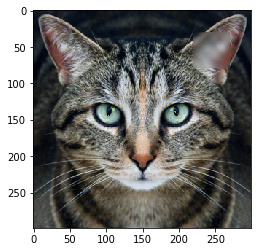

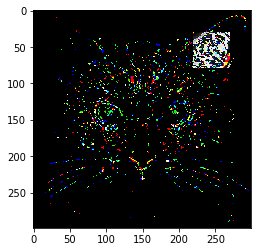

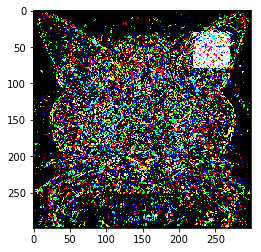

In [11]:
# x_hat = x_img.to(device).mul(1-up_mask) + pert.mul(up_mask)
print(x_hat.shape)
show(x_hat[0].cpu())
pert1 = x_hat.cpu()- x_img
print(pert1.shape)
show(pert1[0])
show(mask[0].cpu())

In [12]:
# 可选，扩展图像，保证内容不超出可视范围
# x_tr = cv2.copyMakeBorder(x_tr, 100, 100, 100, 100, cv2.BORDER_CONSTANT, 0)
w, h = numpy_to_tensor(x_hat).shape[0:2]
anglex = 0
angley = 45
anglez = 0  # 是旋转
fov = 42
r = 0


def rad(x):
    return x * np.pi / 180

def get_warpR():
    global anglex,angley,anglez,fov,w,h,r
    # 镜头与图像间的距离，21为半可视角，算z的距离是为了保证在此可视角度下恰好显示整幅图像
    z = np.sqrt(w ** 2 + h ** 2) / 2 / np.tan(rad(fov / 2))
    # 齐次变换矩阵
    rx = np.array([[1, 0, 0, 0],
                   [0, np.cos(rad(anglex)), -np.sin(rad(anglex)), 0],
                   [0, -np.sin(rad(anglex)), np.cos(rad(anglex)), 0, ],
                   [0, 0, 0, 1]], np.float32)

    ry = np.array([[np.cos(rad(angley)), 0, np.sin(rad(angley)), 0],
                   [0, 1, 0, 0],
                   [-np.sin(rad(angley)), 0, np.cos(rad(angley)), 0, ],
                   [0, 0, 0, 1]], np.float32)

    rz = np.array([[np.cos(rad(anglez)), np.sin(rad(anglez)), 0, 0],
                   [-np.sin(rad(anglez)), np.cos(rad(anglez)), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], np.float32)

    r = rx.dot(ry).dot(rz)

    # 四对点的生成
    pcenter = np.array([h / 2, w / 2, 0, 0], np.float32)

    p1 = np.array([0, 0, 0, 0], np.float32) - pcenter
    p2 = np.array([w, 0, 0, 0], np.float32) - pcenter
    p3 = np.array([0, h, 0, 0], np.float32) - pcenter
    p4 = np.array([w, h, 0, 0], np.float32) - pcenter

    dst1 = r.dot(p1)
    dst2 = r.dot(p2)
    dst3 = r.dot(p3)
    dst4 = r.dot(p4)

    list_dst = [dst1, dst2, dst3, dst4]

    org = np.array([[0, 0],
                    [w, 0],
                    [0, h],
                    [w, h]], np.float32)

    dst = np.zeros((4, 2), np.float32)

    # 投影至成像平面
    for i in range(4):
        dst[i, 0] = list_dst[i][0] * z / (z - list_dst[i][2]) + pcenter[0]
        dst[i, 1] = list_dst[i][1] * z / (z - list_dst[i][2]) + pcenter[1]

    warpR = cv2.getPerspectiveTransform(org, dst)
    return warpR

warpR = get_warpR()
result = cv2.warpPerspective(numpy_to_tensor(x_hat), warpR, (h, w))

In [13]:
_, inv_warpR = cv2.invert(warpR)
result_2 = cv2.warpPerspective(result, inv_warpR, (h, w))

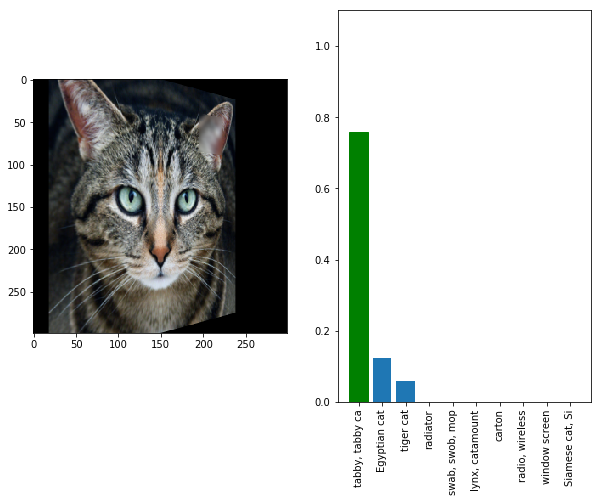

In [14]:
result = np.transpose(result, (2, 0, 1))
result = torch.from_numpy(result)
_ = classify(result,
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([3, 299, 299])
torch.Size([3, 299, 299])


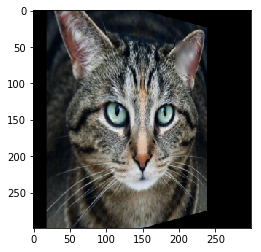

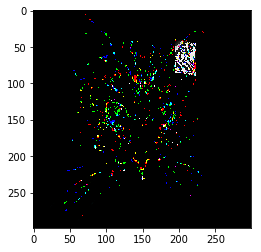

In [15]:
print(result.shape)
show(result)
x_img_t = cv2.warpPerspective(numpy_to_tensor(x_img), warpR, (h, w))
x_img_t = np.transpose(x_img_t, (2, 0, 1))
x_img_t = torch.from_numpy(x_img_t)
pert2 = result - x_img_t
print(pert2.shape)
show(pert2)

In [16]:
learning_rate_gd = 1e-1
momentum = 0.9
epsilon = 2.0/255.0
steps = 200
loss_threshold = 1e-6

# mask = torch.zeros(1,3,299,299).to(device)
# mask[:,:,50:-50,50:-50] = 1

# mask_t = cv2.warpPerspective(numpy_to_tensor(mask), warpR, (h, w))
# mask_t = numpy_to_tensor(mask_t)

# x_trn = x_hat
# x_trn = cv2.warpPerspective(numpy_to_tensor(x_trn), warpR, (h, w))
# x_trn = numpy_to_tensor(x_trn,requires_grad=True)
# x_trn.requires_grad = True
# optimizer = optim.ASGD(params = [x_trn], lr = learning_rate_gd)
optimizer = optim.SGD(params = [mask], lr = learning_rate_gd)

Starting adversarial training...
Progress : pass 10/200; loss = 8.894715309143066
Progress : pass 20/200; loss = 8.89474105834961
Progress : pass 30/200; loss = 8.894763946533203
Progress : pass 40/200; loss = 8.89478874206543
Progress : pass 50/200; loss = 8.894810676574707
Progress : pass 60/200; loss = 8.894837379455566
Progress : pass 70/200; loss = 8.89486312866211
Progress : pass 80/200; loss = 8.894888877868652
Progress : pass 90/200; loss = 8.894917488098145
Progress : pass 100/200; loss = 8.894935607910156
Progress : pass 110/200; loss = 8.894960403442383
Progress : pass 120/200; loss = 8.894987106323242
Progress : pass 130/200; loss = 8.895011901855469
Progress : pass 140/200; loss = 8.895033836364746
Progress : pass 150/200; loss = 8.895063400268555
Progress : pass 160/200; loss = 8.89509105682373
Progress : pass 170/200; loss = 8.895116806030273
Progress : pass 180/200; loss = 8.895142555236816
Progress : pass 190/200; loss = 8.895166397094727
Progress : pass 200/200; loss 

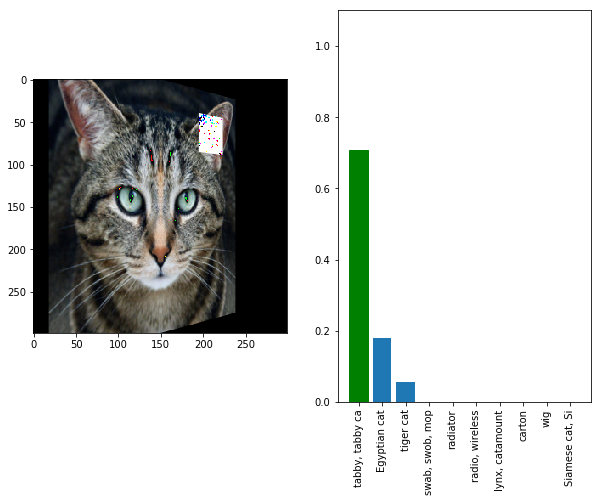

In [17]:
print("Starting adversarial training...")
for i in range(steps):
    optimizer.zero_grad()
#     y_hat = inception_net.forward(x_tr).to(device)
    # [Jun's remark]
    # y_hat = inception_net.forward(geom_transform(x_tr)).to(device) -->
    # e.g.
    # masked_x_trn = mask * x_tr # mask is a binary image of (height, weight)
    # warpped_masked_x_trn = cv2.warpPerspective(masked_x_trn, warpR, (h, w))
    # y_hat = inception_net.forward(warpped_masked_x_trn).to(device)
    
#     x_trn = cv2.warpPerspective(numpy_to_tensor(x_hat), warpR, (h, w))
#     x_trn = numpy_to_tensor(x_trn,requires_grad=True)

#     x_hat = x_img.to(device).mul(1-mask) + pert.mul(mask)
    x_hat = x_img.to(device).mul(1-mask) + mask
    x_trn = cv2.warpPerspective(numpy_to_tensor(x_hat), warpR, (h, w))
    x_trn = numpy_to_tensor(x_trn, requires_grad=True)
    
    y_hat = net.forward(x_trn).to(device)
    loss = criterions(y_hat, y_hat_target)
    loss = l1_coeff*torch.mean(torch.abs(mask)) + tv_coeff*tv_norm(mask, tv_beta) + loss
#         F.softmax(y_hat[0], dim=0)[target_img_class]
    loss.backward()
    
    # Clip gradients
#     x_tr.grad.data.clamp_(-epsilon, epsilon)
    # [Jun's remark]
    # x_tr.grad.data.clamp_(-epsilon, epsilon) -->
    # warpped_masked_x_trn.grad.data.clamp_(-epsilon, epsilon)
    # e.g.
    # masked_x_trn.grad = inverseWarpPerspective()
    # warpped_masked_x_trn = cv2.warpPerspective(masked_x_trn, warpR, (h, w))
    # y_
    mask.grad.data.clamp_(-epsilon, epsilon)
#     x_trn.grad.data.clamp_(-epsilon, epsilon)
    optimizer.step()
#     mask.data.clamp_(0,1)
    if (i+1) % 10 == 0:
        print("Progress : pass " + str(i+1) + "/" + str(steps) + "; loss = " + str(loss.item()))
    if loss.item() < loss_threshold:
        print("Loss below threshold of " + str(loss_threshold) + " reached at epoch " + str(i))
        break

print("Done training...!")

_ = classify(x_trn.squeeze().detach().cpu(), 
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([1, 3, 299, 299])
torch.Size([3, 299, 299])


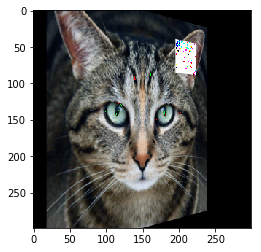

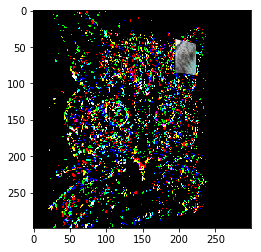

In [18]:
print(x_trn.shape)
show(x_trn[0].cpu())
pert3 = x_trn.squeeze().cpu() - x_img_t
print(pert3.shape)
show(pert3)